In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import pytz

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

In [2]:
sos_download_dir='/storage/elilouis/sublimationofsnow/sosnoqc/'
output_dir='/storage/elilouis/sublimationofsnow/pysumma_inputs/'
output_dir='/storage/elilouis/sublimationofsnow/pysumma_inputs/'
DATE_FORMAT_STR = '%Y%m%d'
start_date = '20221020'
end_date = '20230601'

In [3]:
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [7]:
VARIABLE_NAMES = [
    'P_10m_c', 'T_3m_c', 'RH_3m_c', 'spd_3m_c',  'Rsw_in_9m_d','Rsw_in_uw', 'LWin', 'LWin_uw',
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward Facing Longwave Radiometer (tower D)
    'Rpile_in_9m_d',
    'Tcase_in_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',

    'Tcase_uw',
    'Rpile_in_uw', 'Rpile_out_uw',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Apogee infrared surface temperature sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    'w_h2o__3m_c',
    'w_h2o__5m_c',

    'w_tc__3m_c',
    'w_tc__5m_c',   
]

In [8]:
sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

Caching...skipping download for 20221020
Caching...skipping download for 20221021
Caching...skipping download for 20221022
Caching...skipping download for 20221023
Caching...skipping download for 20221024
Caching...skipping download for 20221025
Caching...skipping download for 20221026
Caching...skipping download for 20221027
Caching...skipping download for 20221028
Caching...skipping download for 20221029
Caching...skipping download for 20221030
Caching...skipping download for 20221031
Caching...skipping download for 20221101
Caching...skipping download for 20221102
Caching...skipping download for 20221103
Caching...skipping download for 20221104
Caching...skipping download for 20221105
Caching...skipping download for 20221106
Caching...skipping download for 20221107
Caching...skipping download for 20221108
Caching...skipping download for 20221109
Caching...skipping download for 20221110
Caching...skipping download for 20221111
Caching...skipping download for 20221112
Caching...skippi

In [9]:
sos_ds = variables.add_longwave_radiation(sos_ds)

In [10]:
sos_ds = variables.add_surface_temps(sos_ds)

/home/elilouis/mambaforge/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/subl

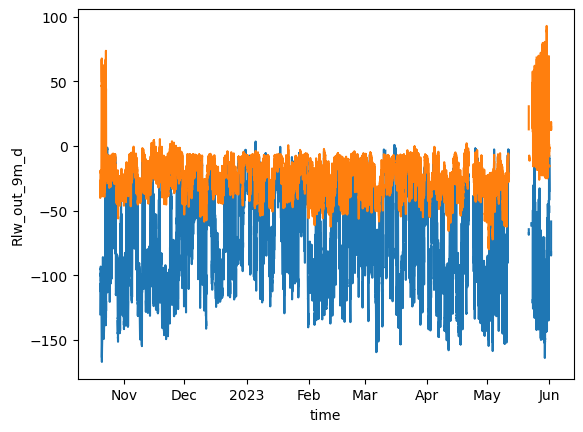

In [11]:
sos_ds['Rlw_in_9m_d'].plot()
sos_ds['Rlw_out_9m_d'].plot()


# Add Tilden precip data

In [18]:
precip_data = pd.concat([
    pd.read_csv("/storage/elilouis/sublimationofsnow/tilden_precip_data/KP22_274-365.PRECIP1", delim_whitespace=True),
    pd.read_csv("/storage/elilouis/sublimationofsnow/tilden_precip_data/KP23_001-177.PRECIP1", delim_whitespace=True)
])
precip_data['time'] = precip_data.apply(lambda row: row['date'] + ' ' + row['time(MST)'], axis=1)
precip_data['time'] = pd.to_datetime(precip_data['time'])
precip_data['time'] = precip_data['time'].apply(lambda t: t - dt.timedelta(minutes=30))
precip_data = precip_data.set_index('time')['Precip_mm']
precip_data

time
2022-10-01 00:00:00    0.0
2022-10-01 00:30:00    0.0
2022-10-01 01:00:00    0.0
2022-10-01 01:30:00    0.0
2022-10-01 02:00:00    0.0
                      ... 
2023-06-26 21:30:00    0.0
2023-06-26 22:00:00    0.0
2023-06-26 22:30:00    0.0
2023-06-26 23:00:00    0.0
2023-06-26 23:30:00    0.0
Name: Precip_mm, Length: 12912, dtype: float64

In [19]:
idx = precip_data.resample('5Min').asfreq().index
precip_data = precip_data.reindex(precip_data.index.union(idx)).resample('5Min').asfreq()
precip_data = precip_data.reset_index()
precip_data['time'] = precip_data['time'].apply(lambda t: t + dt.timedelta(minutes=2, seconds=30))
precip_data = precip_data.set_index('time')
precip_data = precip_data.to_xarray()
sos_ds['precip_mm'] = precip_data.sel(time = slice(
    sos_ds.time.min(), sos_ds.time.max()
))['Precip_mm']

,time,Precip_mm
0,2022-10-01 00:00:00,0.0
1,2022-10-01 00:05:00,NaN
2,2022-10-01 00:10:00,NaN
3,2022-10-01 00:15:00,NaN
4,2022-10-01 00:20:00,NaN
...,...,...
77462,2023-06-26 23:10:00,NaN
77463,2023-06-26 23:15:00,NaN
77464,2023-06-26 23:20:00,NaN
77465,2023-06-26 23:25:00,NaN


# Check data

In [14]:
sos_ds['precip_mm_cum'] = sos_ds['precip_mm'].cumsum()

# Save Datasets

In [20]:
sos_ds.to_netcdf(os.path.join(output_dir ,"kettleponds_sos_pysumma_inputs_5min.cdf"))
# sos_ds.resample(time='30min').mean().to_netcdf(os.path.join(output_dir ,"kettleponds_sos_pysumma_inputs_30min.cdf"))